In [1]:
"""
Persist and Ensemble!
"""
import os
os.system("pip install pandas-ml")

0

In [2]:
import keras.backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import \
    preprocess_input as densenet_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from keras.callbacks import (EarlyStopping, LearningRateScheduler, ReduceLROnPlateau,CSVLogger,
                                        ModelCheckpoint, TensorBoard)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Input
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import get_file
from PIL import Image, ImageFile
from sklearn.metrics import (classification_report, cohen_kappa_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight, shuffle

import imblearn

import warnings
warnings.filterwarnings("ignore")

import pandas_ml as pdml
import cv2

import matplotlib.pyplot as plt
plt.style.use('seaborn')

ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [3]:
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution

In [4]:
CLASSES = 5
LABELS = [0, 1, 2, 3, 4]

HEIGHT = 256
WIDTH = 256
DEPTH = 3

# Image generator information
VALIDATION_SPLIT = 0.1

In [5]:
# Dataset folder information
TRAINING_CSV = "../input/innovation-challenge-2019/training-labels.csv"
DATASET_FOLDER = "../input/innovation-challenge-2019/train/output_combined2"
TESTSET_FOLDER = "../input/innovation-challenge-2019/test/Test"

# Dataset

## Imbalanced dataset

{'0': 9846, '2': 2300, '1': 1027, '3': 648, '4': 324}


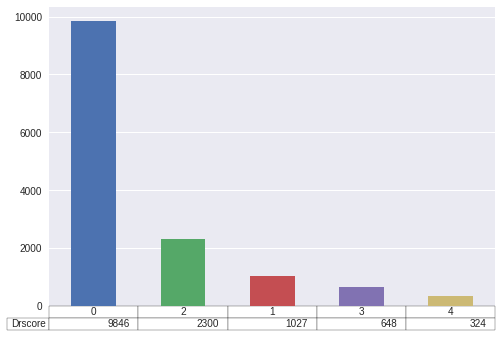

In [6]:
# Load and undersample dataset

DATASET = pd.read_csv(TRAINING_CSV, dtype=str)
# Use pandas-ml
DATASET_ML = pdml.ModelFrame(DATASET, target="Drscore")
samples = DATASET_ML["Drscore"].value_counts().to_dict()
print(samples)
ax = DATASET_ML["Drscore"].value_counts().plot(kind="bar", sort_columns=False, table = True)
ax.get_xaxis().set_visible(False)
ax


## Undersampled dataset for validation

3    324
4    324
0    324
2    324
1    324
Name: Drscore, dtype: int64


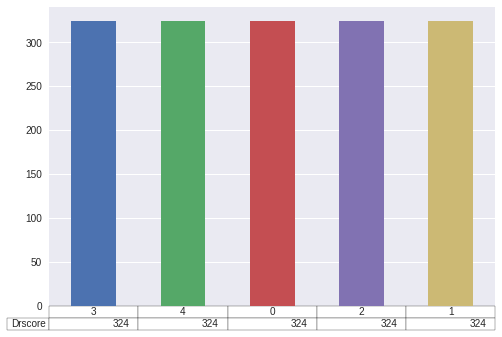

In [7]:
from imblearn.under_sampling import RandomUnderSampler

X = DATASET_ML['Filename'].values.reshape(-1, 1)
y = DATASET_ML['Drscore'].values

X_balanced, y_balanced = RandomUnderSampler(random_state=42).fit_resample(X, y)

DATASET = pdml.ModelFrame({
    "Filename": X_balanced.reshape(-1),
    "Drscore": y_balanced
})

print(DATASET["Drscore"].value_counts())

ax = DATASET["Drscore"].value_counts().plot(kind="bar", sort_columns=False, table = True)
ax.get_xaxis().set_visible(False)
ax

# Validation

## Setup config for validation

In [8]:
preprocessing_function = vgg19_preprocess_input

COLOR_MODE = "grayscale" if DEPTH == 1 else "rgb"
BATCH_SIZE = 128

VALIDATION_GENERATOR_ARGS = {
    "directory":DATASET_FOLDER,
    "x_col":"Filename",
    "y_col":"Drscore",
    "class_mode":"categorical",
    "color_mode":COLOR_MODE,
    "target_size":(HEIGHT, WIDTH),
    "batch_size":BATCH_SIZE,
    "drop_duplicates": False
}

TEST_GENERATOR_ARGS = {
    "directory":DATASET_FOLDER,
    "x_col":"Filename",
    "y_col":"Drscore",
    "class_mode":"categorical",
    "color_mode":COLOR_MODE,
    "target_size":(HEIGHT, WIDTH),
    "batch_size":BATCH_SIZE,
    "shuffle": False
}

VALIDATION_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)

print("[INFO] Creating validation data generator")
VALIDATION_DATA = VALIDATION_DATA_GENERATOR.flow_from_dataframe(dataframe=DATASET, **VALIDATION_GENERATOR_ARGS)

[INFO] Creating validation data generator
Found 1620 validated image filenames belonging to 5 classes.


In [9]:
###################################################################################################
# Cohen Kappa metrics
###################################################################################################


def cohen_kappa(y_true, y_pred):
    y_true_classes = tf.argmax(y_true, 1)
    y_pred_classes = tf.argmax(y_pred, 1)
    return tf.contrib.metrics.cohen_kappa(y_true_classes, y_pred_classes, CLASSES)[1]

In [10]:
VGG19_OVERFITTING_PATH = "../input/sicensemble/vgg19-overfitting.hdf5"
VGG19_OVERSAMPLED_PATH = "../input/sicensemble/vgg19-oversampled.hdf5"

In [11]:
VGG19_OVERFITTING = load_model(VGG19_OVERFITTING_PATH, custom_objects={"cohen_kappa": cohen_kappa})
VGG19_OVERSAMPLED = load_model(VGG19_OVERSAMPLED_PATH, custom_objects={"cohen_kappa": cohen_kappa})

In [12]:
# Initialize tf
K.get_session().run(tf.local_variables_initializer())

In [13]:
testX, y_test = VALIDATION_DATA.next()
testy = np.argmax(y_test, axis=1)

# Calculate ensemble weights

In [14]:
n_members = 2
members = [VGG19_OVERFITTING, VGG19_OVERSAMPLED]

In [15]:
for i in range(n_members):
    _,_, kappa = members[i].evaluate(testX, y_test, verbose=0)
    print(f"Model {i} - {kappa}")    


Model 0 - 0.8463907353612452
Model 1 - 0.8749206882293948


In [16]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # weighted sum across ensemble members
    summed = tensordot(yhats, weights, axes=((0),(0)))
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX = None, testy = None):
    # make prediction
    if not testX:
        testX, y_test = VALIDATION_DATA.next()
        testy = np.argmax(y_test, axis=1)
    
    yhat = ensemble_predictions(members, weights, testX)
    # calculate accuracy
    return cohen_kappa_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized)

## Check ensemble with equal weights

In [17]:
# evaluate averaging ensemble (equal weights)
equal_weights = [1.0/n_members for _ in range(n_members)]
# score = evaluate_ensemble(members, equal_weights)
# print('Equal Weights Score: %.3f' % score)

## Optimize weights with differential evolution of a single batch and check

In [18]:
# # define bounds on each weight
# bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# # arguments to the loss function
# search_arg = (members, testX, testy)
# # global optimization of ensemble weights
# result = differential_evolution(loss_function, bound_w, search_arg, maxiter=10, tol=1e-7)
# # get the chosen weights
# single_validation_optimized_weights = normalize(result['x'])
# print('Optimized Weights: %s' % single_validation_optimized_weights)
# # evaluate chosen weights
# score = evaluate_ensemble(members, single_validation_optimized_weights, testX, testy)
# print('Optimized Weights Score: %.3f' % score)

single_validation_optimized_weights = [0.41598507, 0.58401493]

## Optimize weights with differential evolution of multiple batches and check

In [19]:
# # define bounds on each weight
# bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# # arguments to the loss function
# search_arg = (members, testX, testy)
# # global optimization of ensemble weights
# result = differential_evolution(loss_function, bound_w, search_arg, maxiter=10, tol=1e-7)
# # get the chosen weights
# multiple_validation_optimized_weights = normalize(result['x'])
# print('Optimized Weights: %s' % multiple_validation_optimized_weights)
# # evaluate chosen weights
# score = evaluate_ensemble(members, multiple_validation_optimized_weights)
# print('Optimized Weights Score: %.3f' % score)

multiple_validation_optimized_weights = [0.48217319, 0.51782681]

# Ensembled classification

## Ensembled optimization test

In [20]:
TEST_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)
TEST_DATA = TEST_DATA_GENERATOR.flow_from_dataframe(dataframe=DATASET, **TEST_GENERATOR_ARGS)
TEST_STEPS = len(DATASET)//BATCH_SIZE+1

VGG19_OVERFITTING_PREDICTIONS = VGG19_OVERFITTING.predict_generator(generator=TEST_DATA, steps=TEST_STEPS, verbose=1)
VGG19_OVERFITTING_PREDICTIONS_Y = np.argmax(VGG19_OVERFITTING_PREDICTIONS, axis=1)

Found 1620 validated image filenames belonging to 5 classes.
13/13 [==============================] - 223s 17s/step


In [21]:
CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=VGG19_OVERFITTING_PREDICTIONS_Y , labels=LABELS)
print("CLASSIFICATION_REPORT")
print(CLASSIFICATION_REPORT)

CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=VGG19_OVERFITTING_PREDICTIONS_Y , labels=LABELS)
print("CONFUSION_MATRIX")
print(CONFUSION_MATRIX)

COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=VGG19_OVERFITTING_PREDICTIONS_Y , labels=LABELS)
print("COHEN_KAPPA_SCORE")
print(COHEN_KAPPA_SCORE)

CLASSIFICATION_REPORT
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       324
           1       1.00      0.68      0.81       324
           2       0.76      0.97      0.85       324
           3       0.92      0.87      0.89       324
           4       0.98      0.84      0.90       324

    accuracy                           0.87      1620
   macro avg       0.89      0.87      0.87      1620
weighted avg       0.89      0.87      0.87      1620

CONFUSION_MATRIX
[[317   0   7   0   0]
 [ 71 220  31   1   1]
 [  8   0 314   1   1]
 [  3   1  34 283   3]
 [  3   0  26  24 271]]
COHEN_KAPPA_SCORE
0.8341049382716049


In [22]:
TEST_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)
TEST_DATA = TEST_DATA_GENERATOR.flow_from_dataframe(dataframe=DATASET, **TEST_GENERATOR_ARGS)
TEST_STEPS = len(DATASET)//BATCH_SIZE+1


VGG19_OVERSAMPLED_PREDICTIONS = VGG19_OVERSAMPLED.predict_generator(generator=TEST_DATA, steps=TEST_STEPS, verbose=1)
VGG19_OVERSAMPLED_PREDICTIONS_Y = np.argmax(VGG19_OVERSAMPLED_PREDICTIONS, axis=1)

Found 1620 validated image filenames belonging to 5 classes.
13/13 [==============================] - 216s 17s/step


In [23]:
CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=VGG19_OVERSAMPLED_PREDICTIONS_Y , labels=LABELS)
print("CLASSIFICATION_REPORT")
print(CLASSIFICATION_REPORT)

CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=VGG19_OVERSAMPLED_PREDICTIONS_Y , labels=LABELS)
print("CONFUSION_MATRIX")
print(CONFUSION_MATRIX)

COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=VGG19_OVERSAMPLED_PREDICTIONS_Y , labels=LABELS)
print("COHEN_KAPPA_SCORE")
print(COHEN_KAPPA_SCORE)

CLASSIFICATION_REPORT
              precision    recall  f1-score   support

           0       0.79      0.57      0.67       324
           1       0.74      0.96      0.84       324
           2       0.84      0.82      0.83       324
           3       0.98      0.99      0.99       324
           4       0.99      1.00      1.00       324

    accuracy                           0.87      1620
   macro avg       0.87      0.87      0.86      1620
weighted avg       0.87      0.87      0.86      1620

CONFUSION_MATRIX
[[186  93  43   1   1]
 [ 11 310   3   0   0]
 [ 38  14 266   5   1]
 [  0   0   3 321   0]
 [  0   0   0   0 324]]
COHEN_KAPPA_SCORE
0.8356481481481481


In [24]:
yhats = [VGG19_OVERFITTING_PREDICTIONS, VGG19_OVERSAMPLED_PREDICTIONS]

### Equal weights [0.5, 0.5]

In [25]:
print("Running predictions...")
yhats = array(yhats)
# weighted sum across ensemble members
summed = tensordot(yhats, equal_weights, axes=((0),(0)))
# argmax across classes
EQUAL_WEIGHTS_PREDICTIONS = argmax(summed, axis=1)


CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=EQUAL_WEIGHTS_PREDICTIONS, labels=LABELS)
print("CLASSIFICATION_REPORT")
print(CLASSIFICATION_REPORT)

CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=EQUAL_WEIGHTS_PREDICTIONS, labels=LABELS)
print("CONFUSION_MATRIX")
print(CONFUSION_MATRIX)

COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=EQUAL_WEIGHTS_PREDICTIONS, labels=LABELS)
print("COHEN_KAPPA_SCORE")
print(COHEN_KAPPA_SCORE)

Running predictions...
CLASSIFICATION_REPORT
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       324
           1       0.98      0.88      0.93       324
           2       0.95      0.98      0.97       324
           3       0.99      0.98      0.99       324
           4       1.00      1.00      1.00       324

    accuracy                           0.96      1620
   macro avg       0.96      0.96      0.96      1620
weighted avg       0.96      0.96      0.96      1620

CONFUSION_MATRIX
[[313   6   5   0   0]
 [ 30 286   7   1   0]
 [  5   1 318   0   0]
 [  2   0   3 318   1]
 [  0   0   0   1 323]]
COHEN_KAPPA_SCORE
0.9521604938271605


### Single validation [0.41598507, 0.58401493]

In [26]:
print("Running predictions...")
yhats = array(yhats)
# weighted sum across ensemble members
summed = tensordot(yhats, single_validation_optimized_weights, axes=((0),(0)))
# argmax across classes
SINGLE_VALIDATION_PREDICTIONS = argmax(summed, axis=1)

LABELS = [0, 1, 2, 3, 4]

CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=SINGLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("CLASSIFICATION_REPORT")
print(CLASSIFICATION_REPORT)

CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=SINGLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("CONFUSION_MATRIX")
print(CONFUSION_MATRIX)

COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=SINGLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("COHEN_KAPPA_SCORE")
print(COHEN_KAPPA_SCORE)

Running predictions...
CLASSIFICATION_REPORT
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       324
           1       0.94      0.91      0.93       324
           2       0.95      0.98      0.96       324
           3       1.00      0.99      0.99       324
           4       1.00      1.00      1.00       324

    accuracy                           0.96      1620
   macro avg       0.96      0.96      0.96      1620
weighted avg       0.96      0.96      0.96      1620

CONFUSION_MATRIX
[[296  16  12   0   0]
 [ 26 296   2   0   0]
 [  5   2 317   0   0]
 [  2   0   2 320   0]
 [  0   0   0   0 324]]
COHEN_KAPPA_SCORE
0.9483024691358025


### Mulitple validation [0.48217319 0.51782681]

In [27]:
multiple_validation_optimized_weights

[0.48217319, 0.51782681]

In [28]:
print("Running predictions...")
yhats = array(yhats)
# weighted sum across ensemble members
summed = tensordot(yhats, multiple_validation_optimized_weights, axes=((0),(0)))
# argmax across classes
MULTIPLE_VALIDATION_PREDICTIONS = argmax(summed, axis=1)

LABELS = [0, 1, 2, 3, 4]

CLASSIFICATION_REPORT = classification_report(
    y_true=TEST_DATA.classes, y_pred=MULTIPLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("CLASSIFICATION_REPORT")
print(CLASSIFICATION_REPORT)

CONFUSION_MATRIX = confusion_matrix(
    y_true=TEST_DATA.classes, y_pred=MULTIPLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("CONFUSION_MATRIX")
print(CONFUSION_MATRIX)

COHEN_KAPPA_SCORE = cohen_kappa_score(
    y1=TEST_DATA.classes, y2=MULTIPLE_VALIDATION_PREDICTIONS, labels=LABELS)
print("COHEN_KAPPA_SCORE")
print(COHEN_KAPPA_SCORE)

Running predictions...
CLASSIFICATION_REPORT
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       324
           1       0.97      0.89      0.93       324
           2       0.96      0.98      0.97       324
           3       1.00      0.99      0.99       324
           4       1.00      1.00      1.00       324

    accuracy                           0.96      1620
   macro avg       0.97      0.96      0.96      1620
weighted avg       0.97      0.96      0.96      1620

CONFUSION_MATRIX
[[311   8   5   0   0]
 [ 29 289   6   0   0]
 [  5   1 318   0   0]
 [  2   0   2 320   0]
 [  0   0   0   0 324]]
COHEN_KAPPA_SCORE
0.9552469135802469


# Ensembled submission file

In [29]:
print("Reading Testset for preditions")
TESTSET_ARRAY = [[filename, "0"]
                 for filename in os.listdir(TESTSET_FOLDER)]
TESTSET = pd.DataFrame(TESTSET_ARRAY, columns=["Id", "Expected"])

Reading Testset for preditions


In [30]:
NUM_OF_TESTSET_SAMPLES = len(TESTSET)//BATCH_SIZE+1

TESTSET_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)

print("[INFO] Creating testset data generator")
TESTSET_DATA = TESTSET_DATA_GENERATOR.flow_from_dataframe(dataframe=TESTSET,
                                                          directory=TESTSET_FOLDER,
                                                          x_col="Id",
                                                          y_col="Expected",
                                                          color_mode = COLOR_MODE,
                                                          class_mode="categorical",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=False)

NUM_OF_TESTSET_SAMPLES

[INFO] Creating testset data generator
Found 999 validated image filenames belonging to 1 classes.


8

In [31]:
VGG19_OVERFITTING_PREDICTIONS_TESTSET = VGG19_OVERFITTING.predict_generator(generator=TESTSET_DATA, steps=NUM_OF_TESTSET_SAMPLES, verbose=1)

8/8 [==============================] - 93s 12s/step


In [32]:
NUM_OF_TESTSET_SAMPLES = len(TESTSET)//BATCH_SIZE+1

TESTSET_DATA_GENERATOR = ImageDataGenerator(preprocessing_function=preprocessing_function)

print("[INFO] Creating testset data generator")
TESTSET_DATA = TESTSET_DATA_GENERATOR.flow_from_dataframe(dataframe=TESTSET,
                                                          directory=TESTSET_FOLDER,
                                                          x_col="Id",
                                                          y_col="Expected",
                                                          color_mode = COLOR_MODE,
                                                          class_mode="categorical",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=False)
NUM_OF_TESTSET_SAMPLES

[INFO] Creating testset data generator
Found 999 validated image filenames belonging to 1 classes.


8

In [33]:
VGG19_OVERSAMPLED_PREDICTIONS_TESTSET = VGG19_OVERSAMPLED.predict_generator(generator=TESTSET_DATA, steps=NUM_OF_TESTSET_SAMPLES, verbose=1)

8/8 [==============================] - 77s 10s/step


In [34]:
yhats = [VGG19_OVERFITTING_PREDICTIONS_TESTSET, VGG19_OVERSAMPLED_PREDICTIONS_TESTSET]

print("Running predictions...")
yhats = array(yhats)
# weighted sum across ensemble members
summed = tensordot(yhats, multiple_validation_optimized_weights, axes=((0),(0)))
# argmax across classes
PREDICTIONS = argmax(summed, axis=1)

Running predictions...


In [35]:
TESTSET["Expected"] = PREDICTIONS
TESTSET.to_csv("Submission.csv", index=False)

In [36]:
yhats = [VGG19_OVERFITTING_PREDICTIONS_TESTSET, VGG19_OVERSAMPLED_PREDICTIONS_TESTSET]

print("Running predictions...")
yhats = array(yhats)
# weighted sum across ensemble members
summed = tensordot(yhats, equal_weights, axes=((0),(0)))
# argmax across classes
PREDICTIONS = argmax(summed, axis=1)

NEW_TESTSET = pd.DataFrame(TESTSET_ARRAY, columns=["Id", "Expected"])
NEW_TESTSET["Expected"] = PREDICTIONS

Running predictions...


In [37]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "Submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [38]:
create_download_link(TESTSET)

In [39]:
x=NEW_TESTSET["Expected"] == TESTSET["Expected"]

In [40]:
x[x == False]

216    False
503    False
692    False
809    False
924    False
970    False
972    False
990    False
Name: Expected, dtype: bool